In [1]:
!python --version

Python 3.11.9


In [2]:
%pip install tensorflow keras numpy pandas scikit-learn matplotlib openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import random
import numpy as np
import itertools

import pandas as pd
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [4]:
# Модуль для анализа слов в предложении.
%pip install pymorphy3
import pymorphy3

Note: you may need to restart the kernel to use updated packages.


In [5]:
gc_path = r""
df = pd.read_excel(gc_path+'mails.xlsx')
print(f"{df['class'].unique()=}")
print(f"{df['TYPE_HOTLINE'].unique()=}")


df['class'].unique()=array([1, 6, 5, 2, 3, 4, 8, 7])
df['TYPE_HOTLINE'].unique()=array([2, 1, 3])


In [6]:
df.head(2)

,CONTENT,TYPE_HOTLINE,class
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6


In [7]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)
# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }
hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head()

,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная


Классы сообщений:

In [8]:
cls_list = []
for i in range(1, len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])
cls_list

['Условия подачи',
 'Проходной и допустимый балл',
 'Достижения',
 'Общежития',
 'Вступительные испытания',
 'Перевод',
 'Аспирантура',
 'Регистрация']

In [9]:
df.shape

(588, 5)

### Анализ, визуализация и сбалансированность датасета

In [10]:
g = df.groupby('cls_name')['cls_name'].count().sort_values()
print(g)

cls_name
Аспирантура                      5
Регистрация                     16
Проходной и допустимый балл     24
Общежития                       28
Достижения                      29
Перевод                         42
Вступительные испытания        155
Условия подачи                 289
Name: cls_name, dtype: int64


In [11]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
g

TYPE_HOTLINE
3      6
1     45
2    537
Name: TYPE_HOTLINE, dtype: int64

# Задача 1. Подготовка данных
Предобработка текста писем: удаление из текста лишней информации, которая не нужна для получения основной мысли сообщения и классификации его.

#### Приведение слов в нормальную форму

In [12]:
bad_dict = {
    'мочь',
    # 'сказать',
    # 'подсказать',
    # 'быть',
    "хотеть",
    "хотеться",
    # "есть",
    "узнать",
    "знать",
    "вопрос",
    "уточнить",
    "уважние",
}

def morphan(word, morph):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = word.strip()  # Удаляет пробелы до и после слова
    p = morph.parse(word)[0]  # Разбираем (анализируем) слово с pymorphy3

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        #существительное не ФИО
        word_new = p.normal_form
    elif 'Surn' in p.tag:
        # word_new = 'ФАМИЛИЯ'
        word_new = ''
    elif 'Name' in p.tag:
        # word_new = 'ИМЯ'
        word_new = ''
    elif 'Patr' in p.tag:
        # word_new = 'ОТЧЕСТВО'
        word_new = ''


    elif ('INFN' in p.tag) or ('VERB' in p.tag): #глагол
        word_new = p.normal_form

    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag): #прилагательное
        # word_new = p.normal_form
        word_new = ''

    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag): #причастие, похоже на глагол
        # word_new = p.normal_form
        word_new = ''

    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag):
        # предлоги, местоимения и пр.
        # word_new = p.normal_form
        word_new = ''

    elif ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):
        word_new = ''

    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag) or ('ROMN' in p.tag) or ('UNKN' in p.tag): # числительные NUMB, межометия intg
        word_new = ''

    else:
        word_new = word

    if word_new in bad_dict:
        word_new = ''
    return word_new

def normtext(txt, morph):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    txt = re.sub(r"[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', txt)  # заменяем знаки пунктуаци и спецсиволы на пробелы
    return str(' '.join([morphan(x, morph) for x in txt.split()]))


Пример:

In [13]:
morph = pymorphy3.MorphAnalyzer()
normtext('Расскажите, пожалуйста, Иван Васильевич, какие условия поступления в 2025 году?', morph)

'рассказать     условие поступление   год'

In [14]:
df['text'] = df.CONTENT.map(lambda x: normtext(x, morph))

In [15]:
# Сохраняем обработанные данные
df.to_excel(gc_path+r'df_prep.xlsx', index=False)

# ML - Классификация


#### Подбор параметра

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)

tfv = TfidfVectorizer()  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid = {'C': [1.,10.0]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

grid_search.best_params_

{'C': 10.0}

{'C': 10.0}

In [17]:
def classifier(X_train, y_train, C=10.):
    '''
    Возвращает обученный классификатор и векторизатор.
    '''

    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    clf = LogisticRegression(C=C)
    clf = clf.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор

    '''
    X_test = tfv.transform([text])

    pred = clf.predict(X_test)

    return pred[0]

In [18]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
tfv, clf = classifier(X_train, y_train, C=10.0)

In [19]:
# Предсказание
pred_save = []
class_save = []
pred = []
for nom, txt in enumerate(X_test.values):
    pred.append(predictor(txt, clf, tfv))


In [20]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

                Аспирантура       0.00      0.00      0.00         1
    Вступительные испытания       0.98      0.88      0.92        49
                 Достижения       0.67      0.50      0.57         8
                  Общежития       0.45      1.00      0.62         5
                    Перевод       1.00      0.17      0.29         6
Проходной и допустимый балл       0.89      0.73      0.80        11
                Регистрация       1.00      0.25      0.40         8
             Условия подачи       0.83      0.97      0.89        89

                   accuracy                           0.84       177
                  macro avg       0.73      0.56      0.56       177
               weighted avg       0.86      0.84      0.83       177



d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


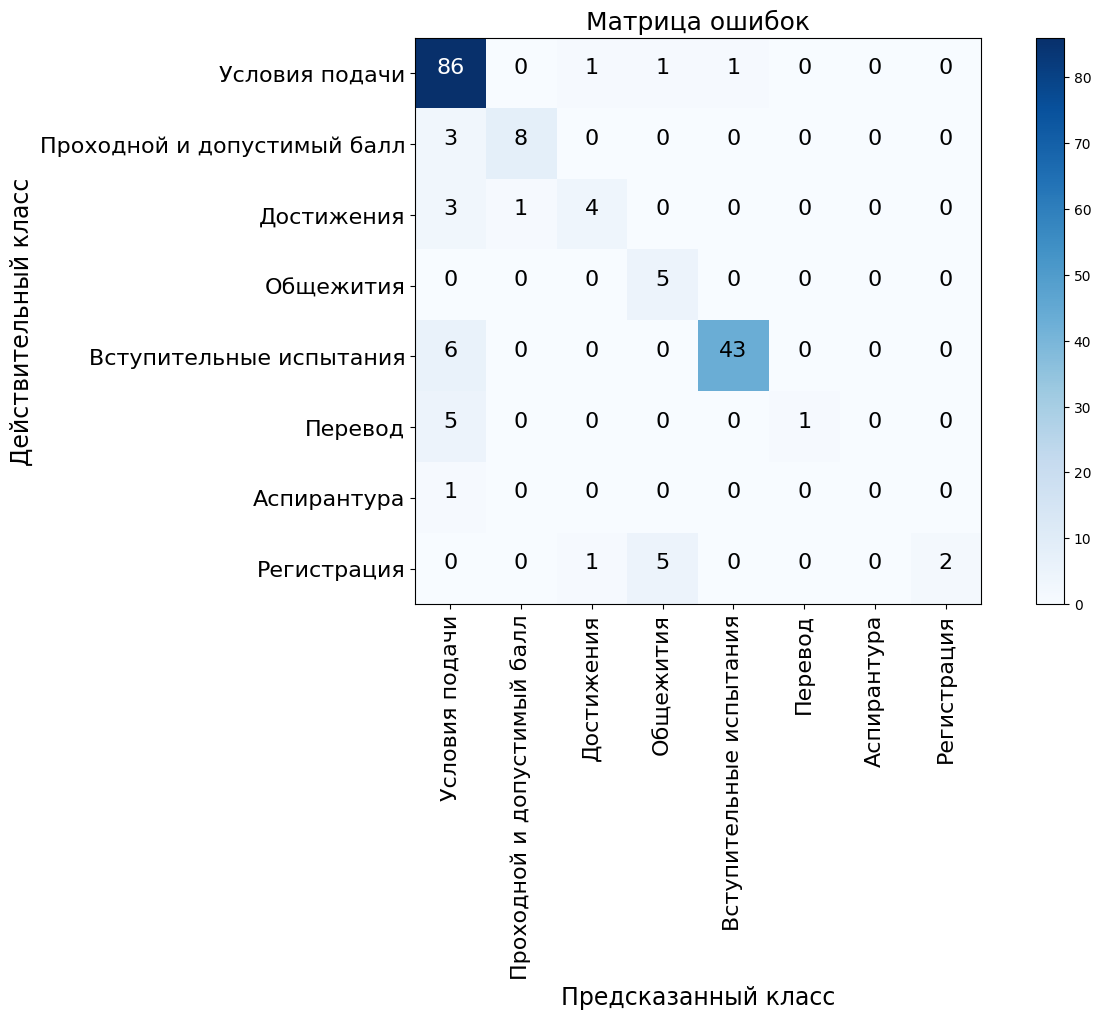

In [21]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

#  RNN - классификация

In [22]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM


# LSTM

In [23]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

In [24]:
X_train_1, X_vt_1, y_train_1, y_vt_1 = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_vt_1, y_vt_1, test_size=0.5, random_state=42)

In [25]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words

Максимальное количество слов в самом длинном письме: 45 слов
Всего уникальных слов в словаре: 791


In [26]:
# Преобразуем описания заявок в векторы чисел
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.text)

X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)

num_classes = df['class'].unique().shape[0]+1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Размерность X_train: (411, 45)
Размерность X_valid: (88, 45)
Размерность X_test: (89, 45)
y_train shape: (411, 9)
y_valid shape: (88, 9)
y_test shape: (89, 9)


In [27]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.3635 - loss: 2.1616 - val_accuracy: 0.5000 - val_loss: 1.9492
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4770 - loss: 1.8427 - val_accuracy: 0.5000 - val_loss: 1.5138
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4736 - loss: 1.5555 - val_accuracy: 0.5000 - val_loss: 1.4826
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4462 - loss: 1.5396 - val_accuracy: 0.5000 - val_loss: 1.4564
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4875 - loss: 1.4906 - val_accuracy: 0.5000 - val_loss: 1.4259
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5288 - loss: 1.3963 - val_accuracy: 0.5000 - val_loss: 1.3940
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5203 - loss: 1.3863 - val_accuracy: 0.5455 - val_loss: 1.3458
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5937 - loss: 1.3164 - val_

In [29]:
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


In [30]:
print(classification_report(y2, pred2))

              precision    recall  f1-score   support

           1       0.76      0.93      0.84        45
           2       0.00      0.00      0.00         3
           3       0.67      0.50      0.57         4
           4       0.29      1.00      0.44         2
           5       0.95      0.76      0.84        25
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.74        89
   macro avg       0.36      0.43      0.37        89
weighted avg       0.70      0.74      0.71        89



d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


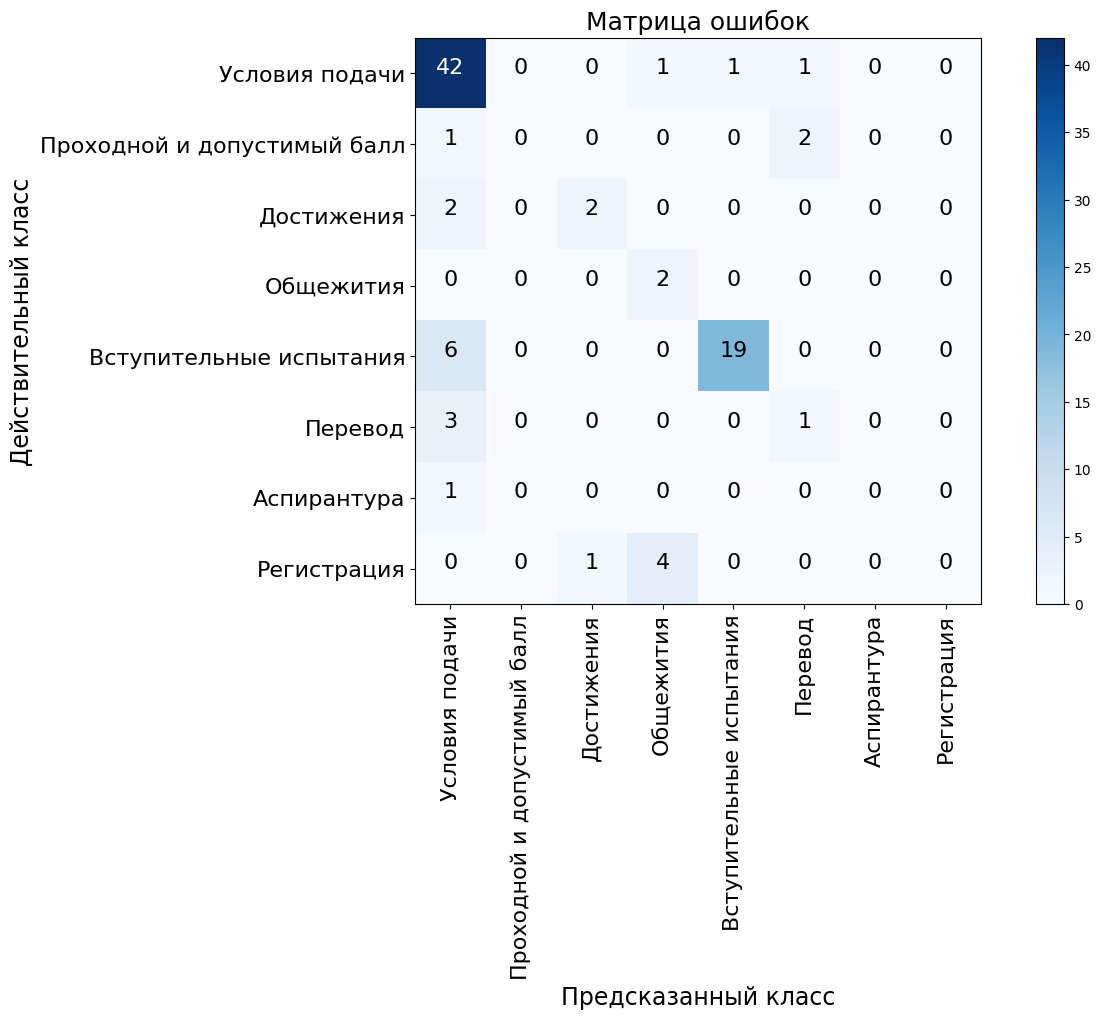

In [31]:
# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# Параметры LSTM

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3507 - loss: 2.1460 - val_accuracy: 0.5000 - val_loss: 1.8465
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4147 - loss: 1.7831 - val_accuracy: 0.5000 - val_loss: 1.5380
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4739 - loss: 1.5566 - val_accuracy: 0.5000 - val_loss: 1.4648
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4752 - loss: 1.4511 - val_accuracy: 0.5000 - val_loss: 1.4398
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4846 - loss: 1.4477 - val_accuracy: 0.5000 - val_loss: 1.4177
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5306 - loss: 1.3481 - val_accuracy: 0.5227 - val_loss: 1.3872
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5519 - loss: 1.3618 - val_accuracy: 0.5909 - val_loss: 1.3328
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5721 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


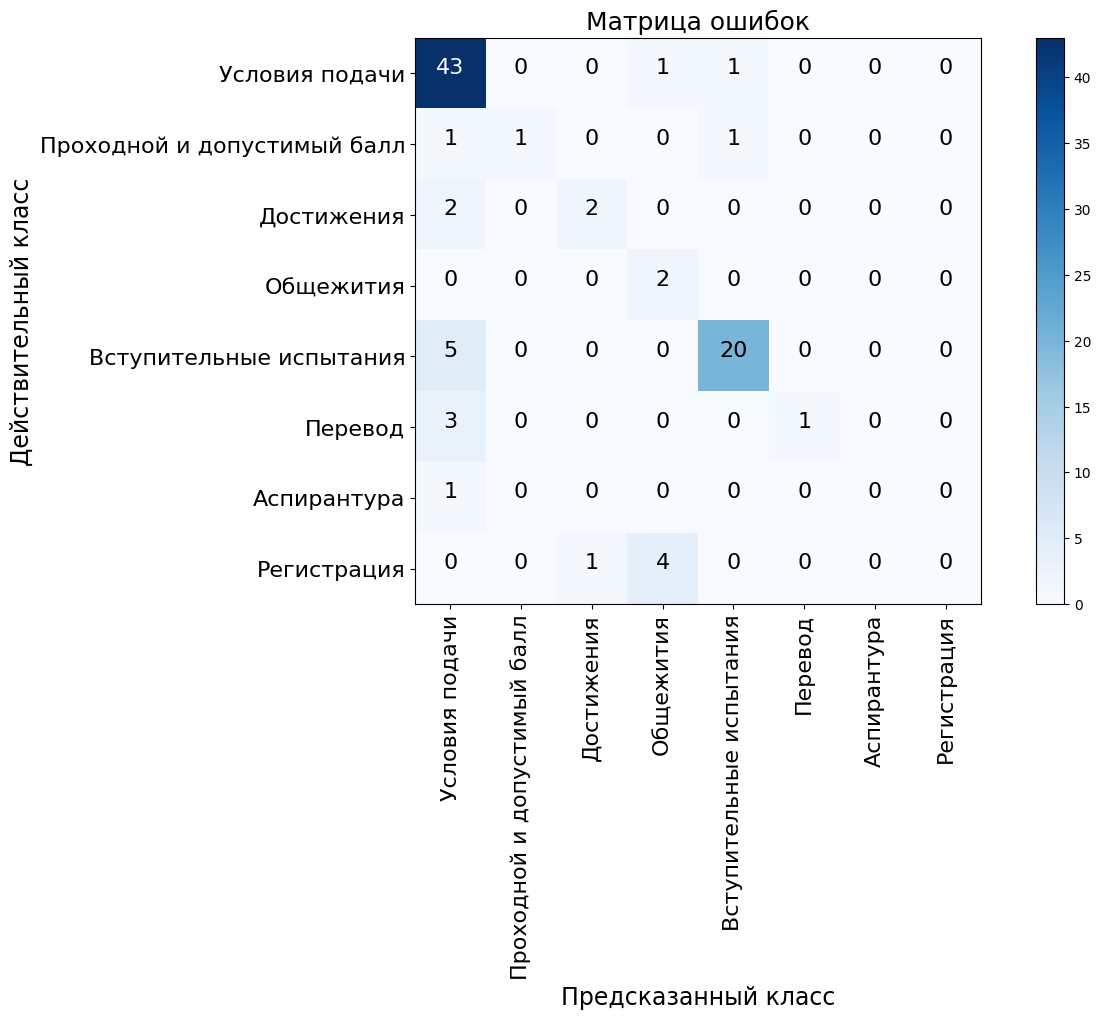

In [32]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.4012 - loss: 2.1267 - val_accuracy: 0.5000 - val_loss: 1.7730
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4928 - loss: 1.6565 - val_accuracy: 0.5000 - val_loss: 1.5626
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4847 - loss: 1.5158 - val_accuracy: 0.5000 - val_loss: 1.4924
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4967 - loss: 1.4814 - val_accuracy: 0.5000 - val_loss: 1.4718
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4635 - loss: 1.4587 - val_accuracy: 0.5000 - val_loss: 1.4471
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4635 - loss: 1.4778 - val_accuracy: 0.5227 - val_loss: 1.4106
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5353 - loss: 1.3192 - val_accuracy: 0.5909 - val_loss: 1.3346
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6203 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


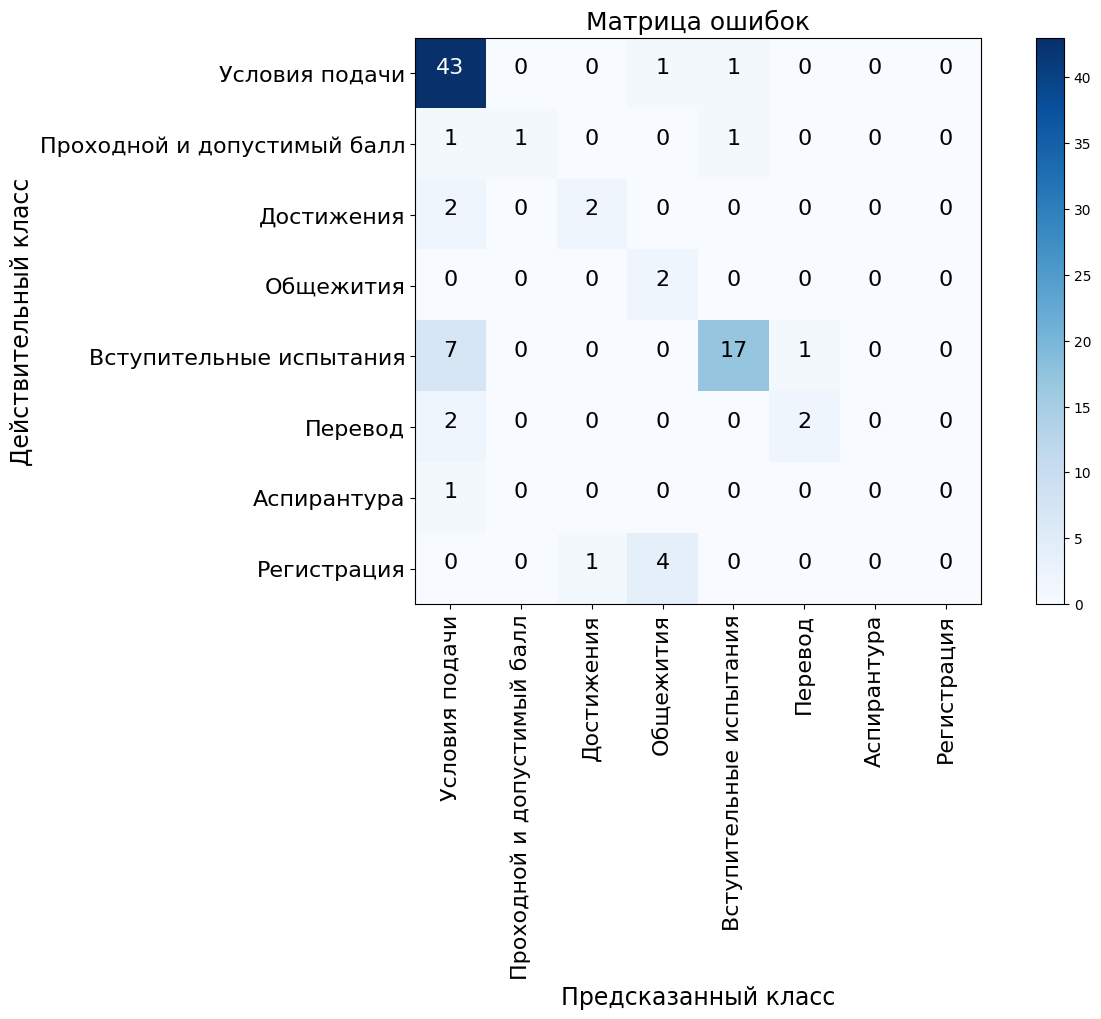

In [33]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.3831 - loss: 2.1678 - val_accuracy: 0.5000 - val_loss: 1.9829
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4654 - loss: 1.8723 - val_accuracy: 0.5000 - val_loss: 1.4921
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4949 - loss: 1.5307 - val_accuracy: 0.5000 - val_loss: 1.4750
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4743 - loss: 1.5312 - val_accuracy: 0.5000 - val_loss: 1.4492
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5219 - loss: 1.3819 - val_accuracy: 0.5000 - val_loss: 1.4102
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5067 - loss: 1.3822 - val_accuracy: 0.5341 - val_loss: 1.3655
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5580 - loss: 1.3259 - val_accuracy: 0.5909 - val_loss: 1.2943
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6229 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


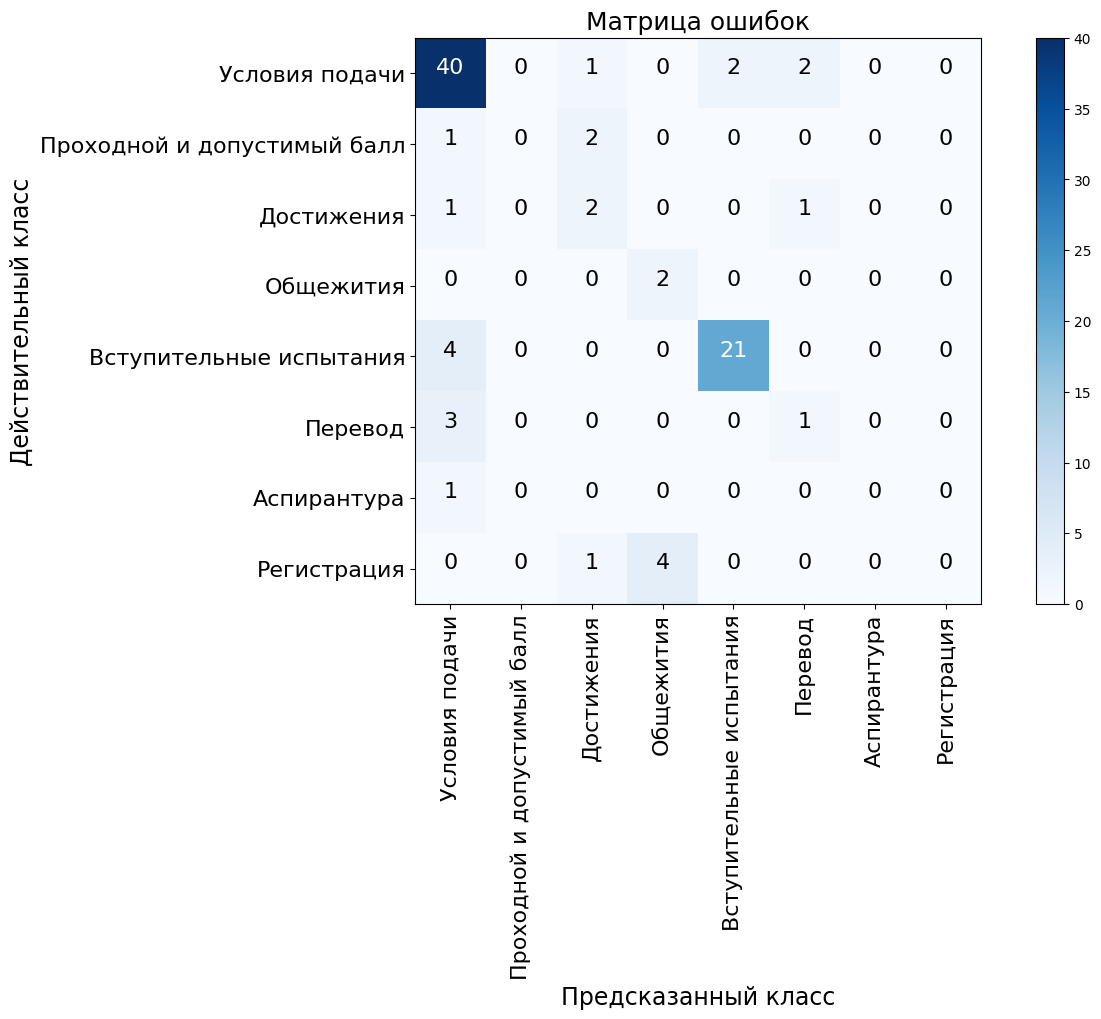

In [34]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.3838 - loss: 2.1674 - val_accuracy: 0.5114 - val_loss: 2.0122
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4777 - loss: 1.9377 - val_accuracy: 0.5000 - val_loss: 1.5627
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5095 - loss: 1.5987 - val_accuracy: 0.5000 - val_loss: 1.4925
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4746 - loss: 1.5759 - val_accuracy: 0.5000 - val_loss: 1.4638
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4472 - loss: 1.5213 - val_accuracy: 0.5000 - val_loss: 1.4434
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4992 - loss: 1.5163 - val_accuracy: 0.5000 - val_loss: 1.4223
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5029 - loss: 1.3811 - val_accuracy: 0.5568 - val_loss: 1.3674
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5456 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


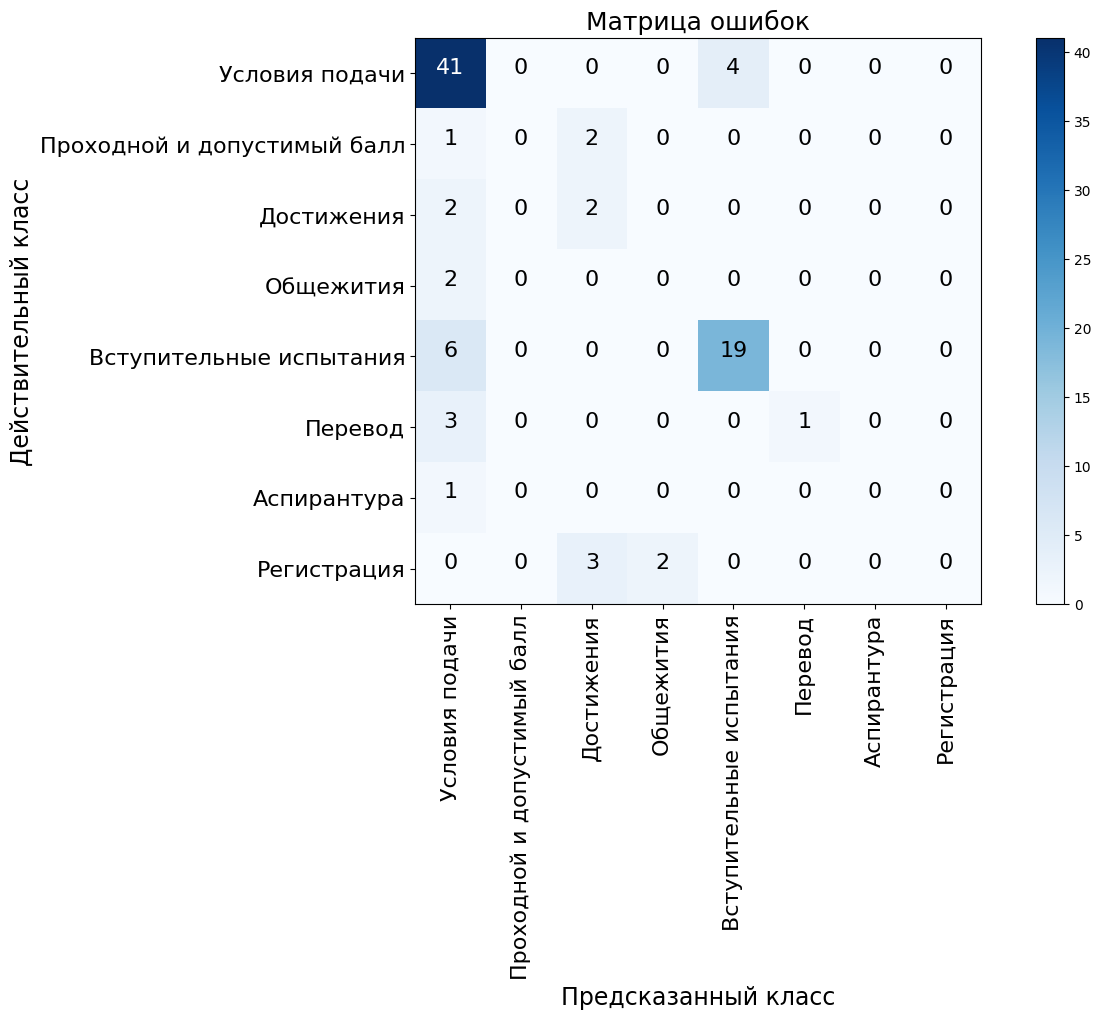

In [35]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(25, dropout=0.1, recurrent_dropout=0.25))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# Оптимизаторы

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.3697 - loss: 2.1711 - val_accuracy: 0.5000 - val_loss: 2.0119
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5269 - loss: 1.8793 - val_accuracy: 0.5000 - val_loss: 1.4452
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4945 - loss: 1.4959 - val_accuracy: 0.5000 - val_loss: 1.4240
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4825 - loss: 1.4429 - val_accuracy: 0.5000 - val_loss: 1.4110
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5711 - loss: 1.3497 - val_accuracy: 0.6023 - val_loss: 1.3409
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6554 - loss: 1.2547 - val_accuracy: 0.6136 - val_loss: 1.2777
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6837 - loss: 1.1660 - val_accuracy: 0.6932 - val_loss: 1.1865
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7149 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


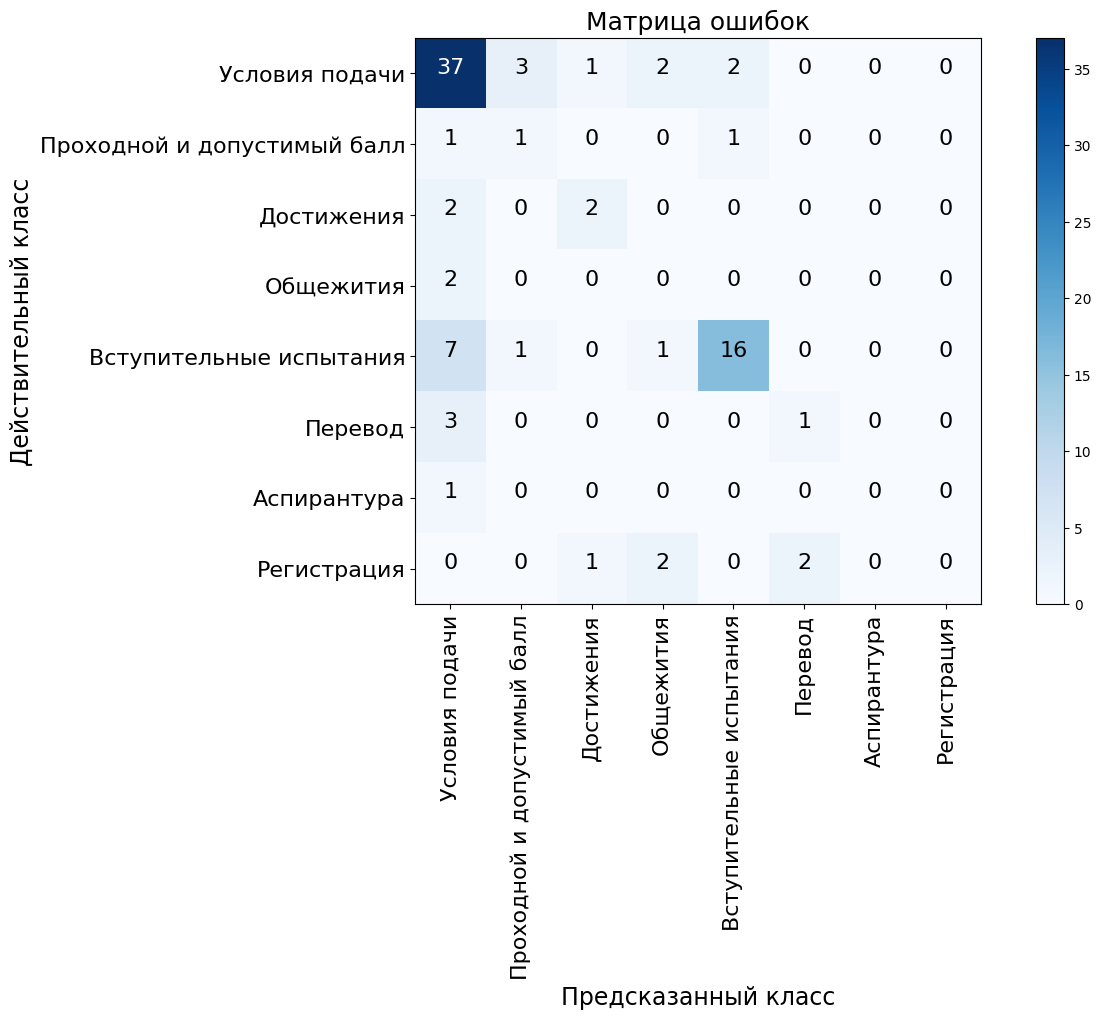

In [36]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='lion',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.3193 - loss: 2.1851 - val_accuracy: 0.5000 - val_loss: 2.1474
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4360 - loss: 2.1334 - val_accuracy: 0.5000 - val_loss: 2.0761
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5005 - loss: 2.0359 - val_accuracy: 0.5000 - val_loss: 1.9076
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5187 - loss: 1.8188 - val_accuracy: 0.5000 - val_loss: 1.6352
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4704 - loss: 1.6428 - val_accuracy: 0.5000 - val_loss: 1.5415
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4811 - loss: 1.5155 - val_accuracy: 0.5000 - val_loss: 1.5052
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4957 - loss: 1.5017 - val_accuracy: 0.5000 - val_loss: 1.4785
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5060 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


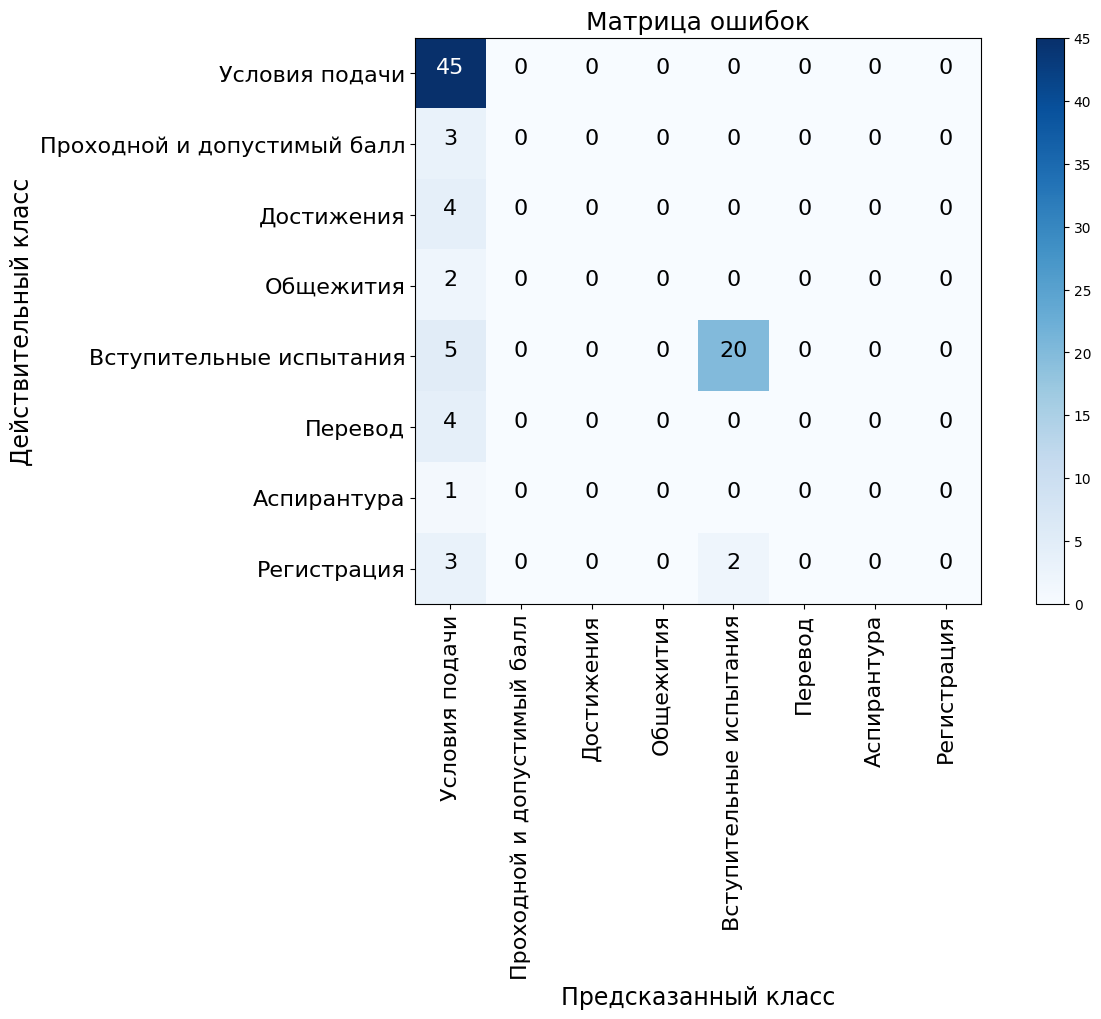

In [37]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.3555 - loss: 2.1788 - val_accuracy: 0.5000 - val_loss: 2.1209
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4728 - loss: 2.1099 - val_accuracy: 0.5000 - val_loss: 2.0491
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4874 - loss: 2.0429 - val_accuracy: 0.5000 - val_loss: 1.9808
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4669 - loss: 1.9887 - val_accuracy: 0.5000 - val_loss: 1.9152
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5012 - loss: 1.9089 - val_accuracy: 0.5000 - val_loss: 1.8557
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4921 - loss: 1.8581 - val_accuracy: 0.5000 - val_loss: 1.8020
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5318 - loss: 1.7693 - val_accuracy: 0.5000 - val_loss: 1.7566
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4839 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


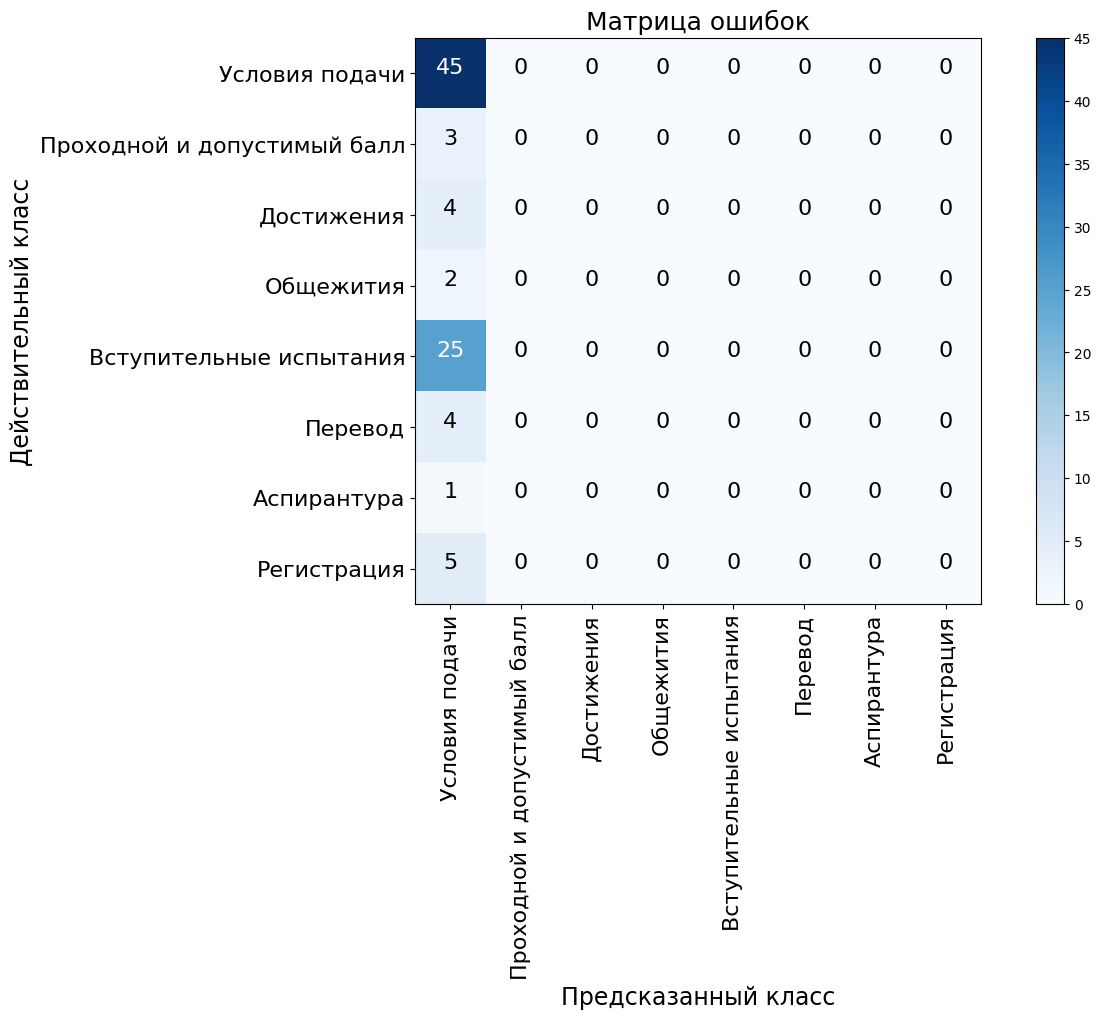

In [38]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# Функции активации

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.0423 - loss: 6.9081 - val_accuracy: 0.0114 - val_loss: 8.8839
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.0420 - loss: 9.1912 - val_accuracy: 0.0341 - val_loss: 9.4696
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1451 - loss: 9.9717 - val_accuracy: 0.0455 - val_loss: 8.8113
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1593 - loss: 9.2316 - val_accuracy: 0.0455 - val_loss: 7.2239
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.1768 - loss: 8.1773 - val_accuracy: 0.0455 - val_loss: 6.2038
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.1759 - loss: 7.3964 - val_accuracy: 0.0455 - val_loss: 5.7614
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.1644 - loss: 8.9656 - val_accuracy: 0.0455 - val_loss: 9.3526
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.1910

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


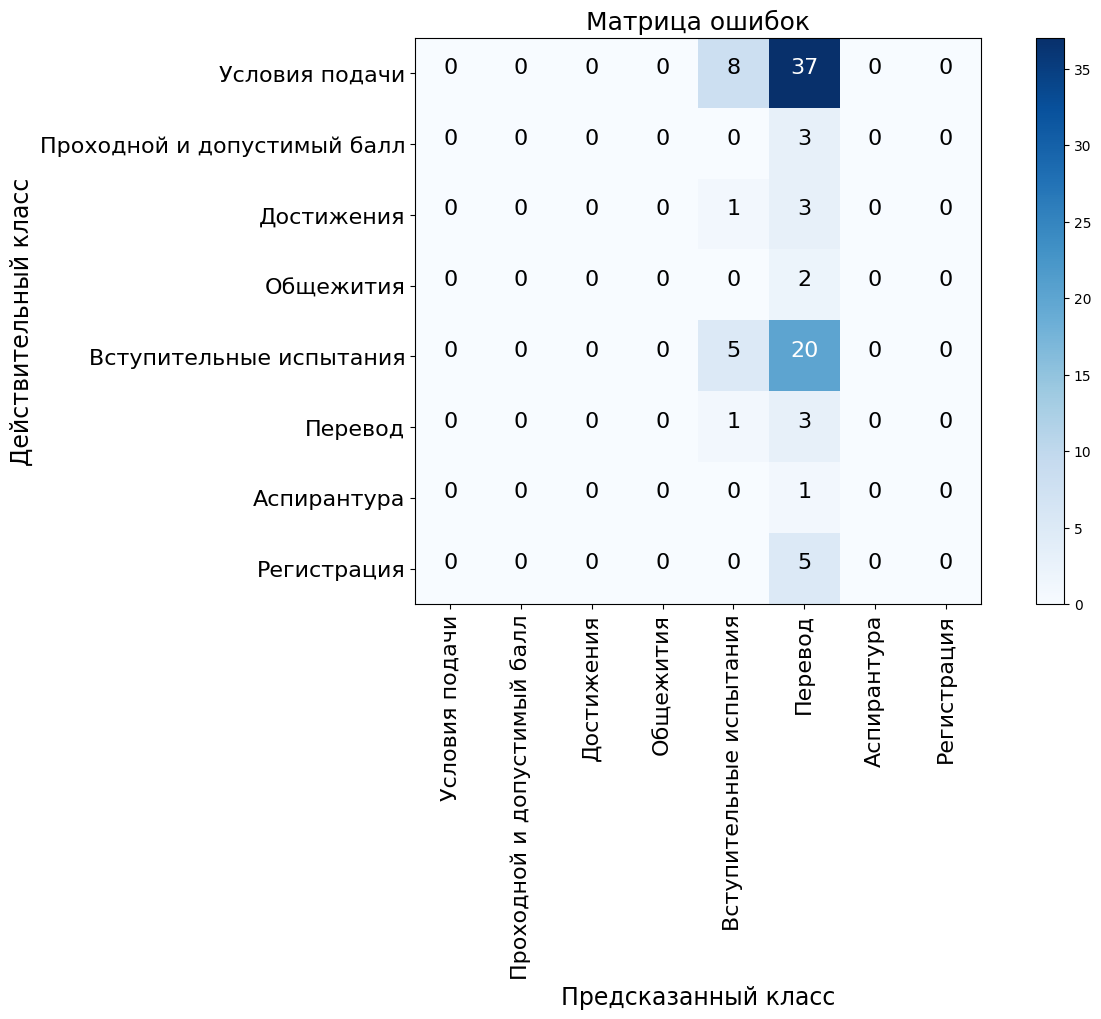

In [39]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='linear'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3132 - loss: 2.1694 - val_accuracy: 0.5000 - val_loss: 2.0141
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4509 - loss: 1.9239 - val_accuracy: 0.5000 - val_loss: 1.6697
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4749 - loss: 1.6445 - val_accuracy: 0.5000 - val_loss: 1.5368
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4595 - loss: 1.5353 - val_accuracy: 0.5000 - val_loss: 1.4636
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4897 - loss: 1.5147 - val_accuracy: 0.5341 - val_loss: 1.4050
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5702 - loss: 1.3219 - val_accuracy: 0.6250 - val_loss: 1.3382
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6543 - loss: 1.2557 - val_accuracy: 0.6364 - val_loss: 1.2360
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6598 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


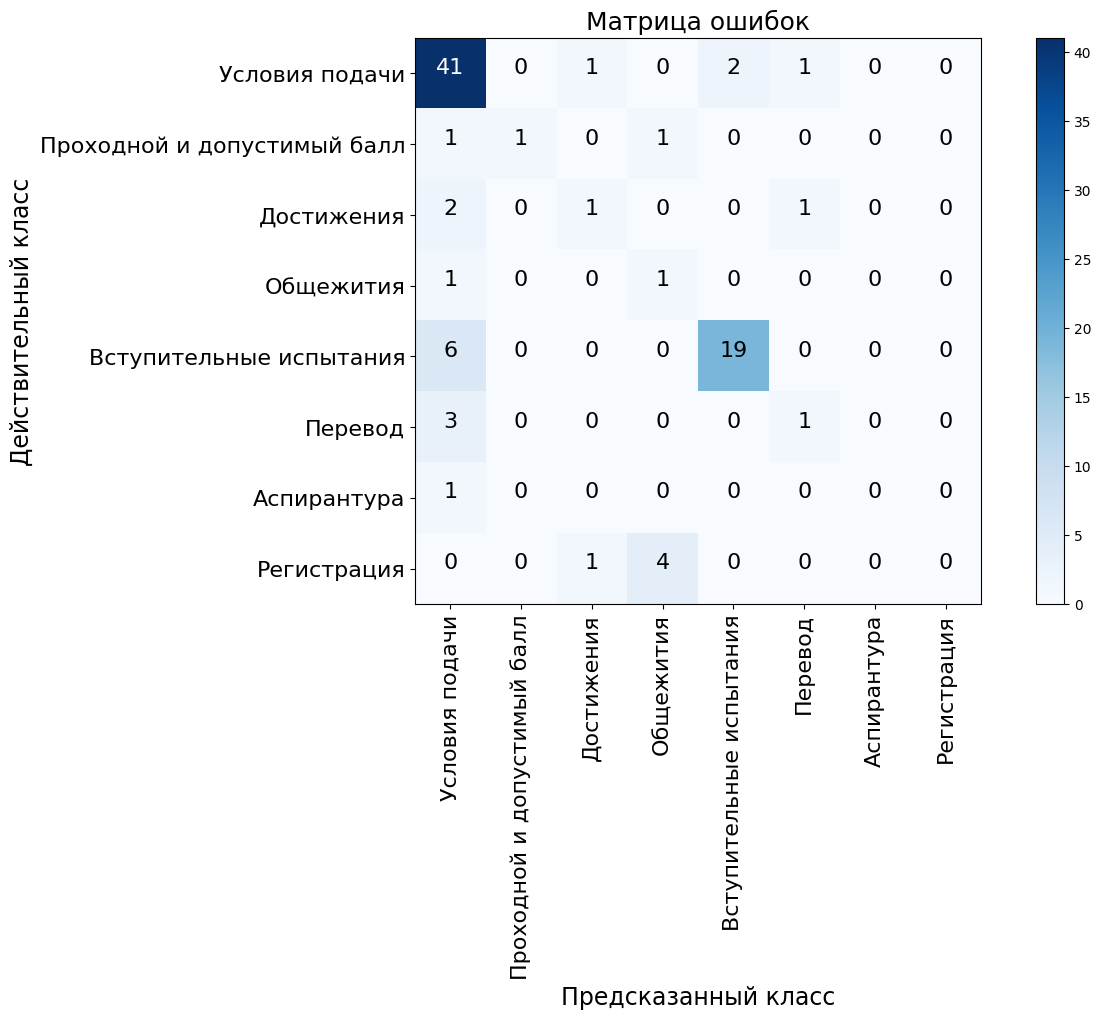

In [40]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.2806 - loss: 7.8034 - val_accuracy: 0.4886 - val_loss: 9.3144
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4783 - loss: 9.8333 - val_accuracy: 0.4886 - val_loss: 9.4933
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4782 - loss: 8.6571 - val_accuracy: 0.4886 - val_loss: 7.1532
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4687 - loss: 7.6803 - val_accuracy: 0.5000 - val_loss: 8.1131
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4661 - loss: 8.4606 - val_accuracy: 0.4205 - val_loss: 8.0974
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2084 - loss: 8.5787 - val_accuracy: 0.1250 - val_loss: 9.7267
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0783 - loss: 8.4889 - val_accuracy: 0.0795 - val_loss: 9.7098
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0525 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


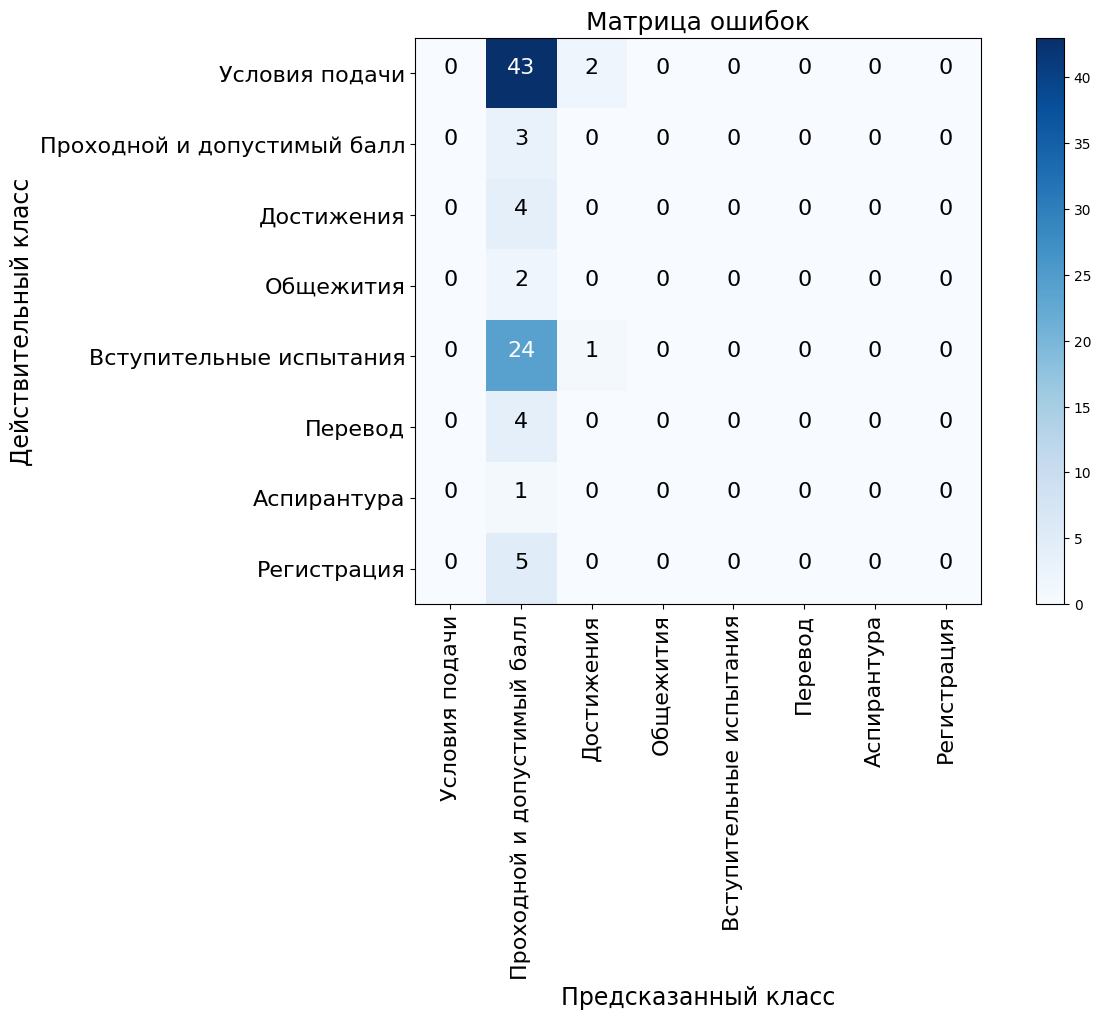

In [41]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='swish'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# Функция ошибок

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3568 - loss: 1.0009 - val_accuracy: 0.5000 - val_loss: 0.9991
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5639 - loss: 0.9979 - val_accuracy: 0.5795 - val_loss: 0.9961
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6710 - loss: 0.9935 - val_accuracy: 0.5909 - val_loss: 0.9858
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5823 - loss: 0.9727 - val_accuracy: 0.5000 - val_loss: 0.9184
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5317 - loss: 0.8910 - val_accuracy: 0.6136 - val_loss: 0.8054
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5959 - loss: 0.8041 - val_accuracy: 0.5682 - val_loss: 0.7937
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6384 - loss: 0.7415 - val_accuracy: 0.6591 - val_loss: 0.6941
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6590 - 

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


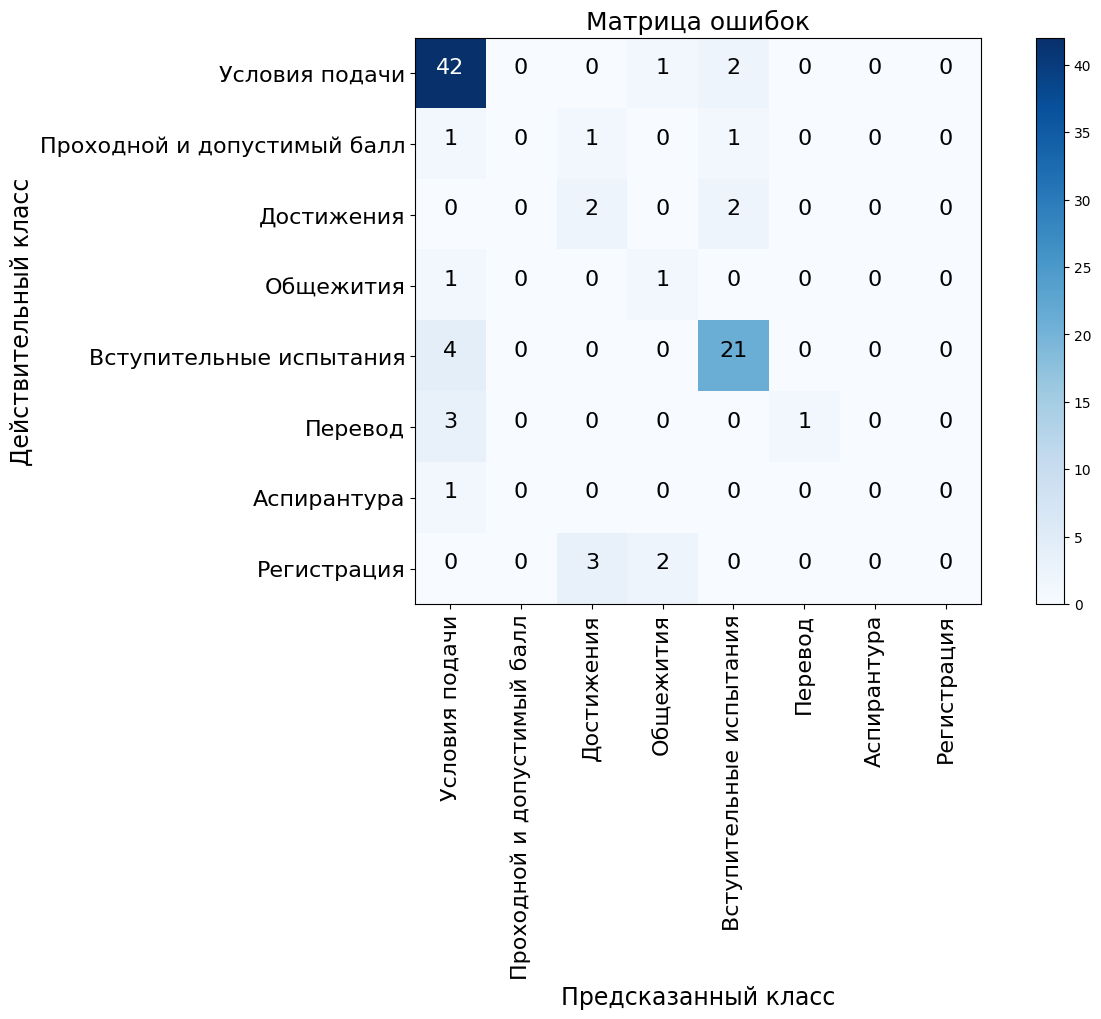

In [42]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.3305 - loss: -0.3461 - val_accuracy: 0.4886 - val_loss: -0.4194
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5020 - loss: -0.4547 - val_accuracy: 0.5000 - val_loss: -0.5822
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4477 - loss: -0.5531 - val_accuracy: 0.5000 - val_loss: -0.5958
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4762 - loss: -0.5771 - val_accuracy: 0.5114 - val_loss: -0.6116
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5538 - loss: -0.5838 - val_accuracy: 0.5682 - val_loss: -0.6329
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6336 - loss: -0.6867 - val_accuracy: 0.6932 - val_loss: -0.6560
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6947 - loss: -0.6773 - val_accuracy: 0.6705 - val_loss: -0.6897
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accur

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


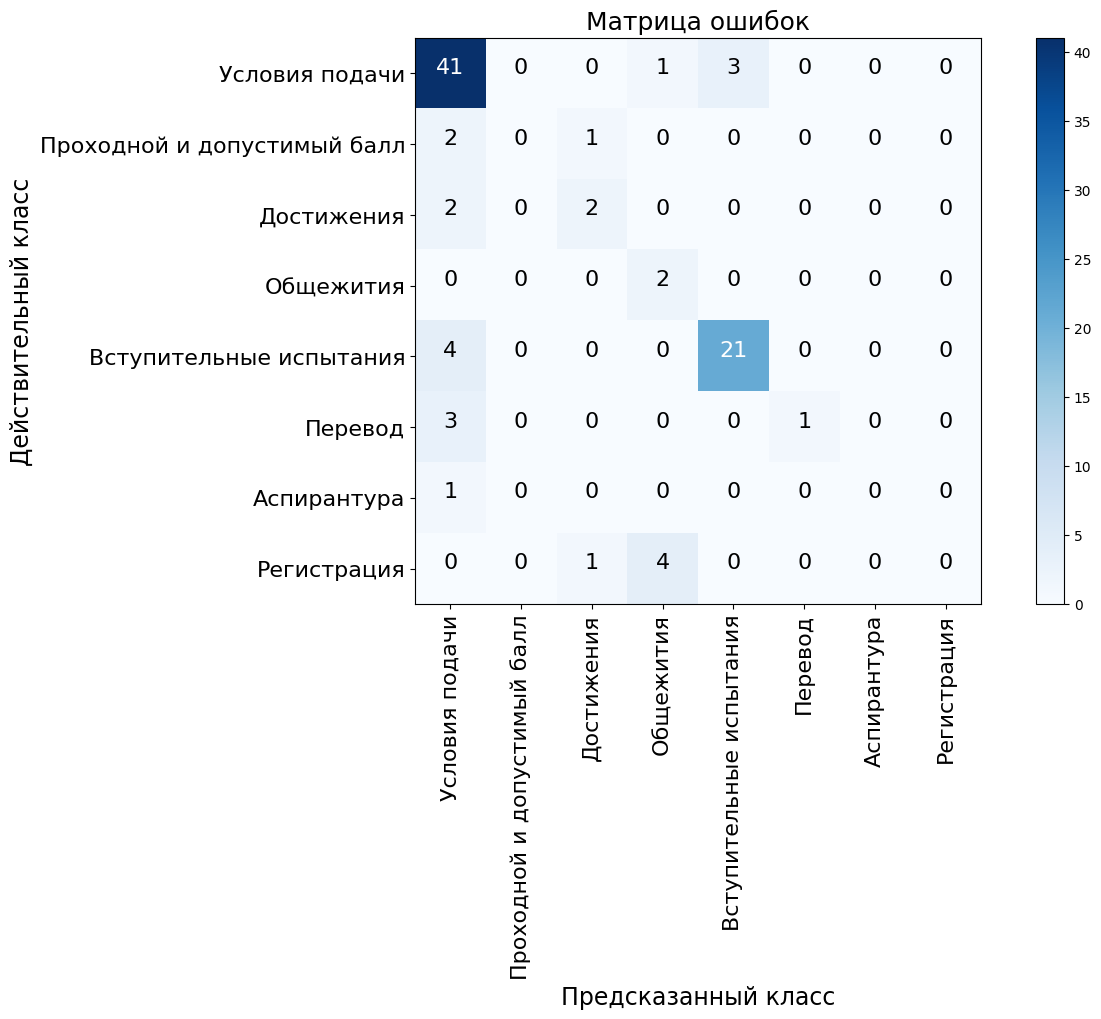

In [43]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='cosine_similarity',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# GRU

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.2890 - loss: 1.0016 - val_accuracy: 0.6023 - val_loss: 0.9987
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6035 - loss: 0.9972 - val_accuracy: 0.6136 - val_loss: 0.9950
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6428 - loss: 0.9915 - val_accuracy: 0.6136 - val_loss: 0.9853
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6260 - loss: 0.9664 - val_accuracy: 0.5795 - val_loss: 0.9166
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5166 - loss: 0.8900 - val_accuracy: 0.6364 - val_loss: 0.8533
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6326 - loss: 0.7816 - val_accuracy: 0.6364 - val_loss: 0.7529
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7045 - loss: 0.6575 - val_accuracy: 0.6591 - val_loss: 0.7144
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6548 -

d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


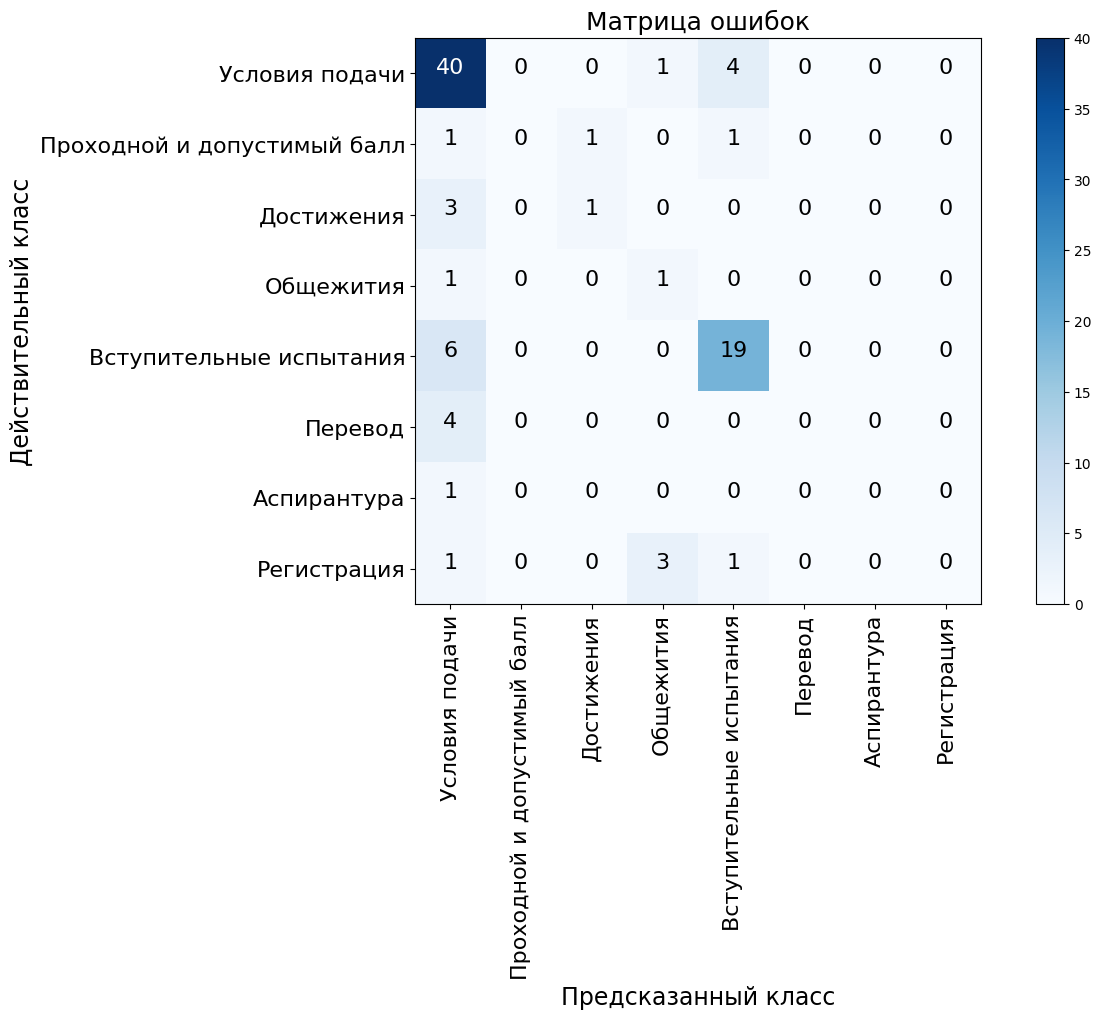

In [44]:
from keras.layers import GRU
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(GRU(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

# Стекинг

Note: you may need to restart the kernel to use updated packages.


d:\db\py\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\db\py\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\db\py\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\db\py\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set t

              precision    recall  f1-score   support

           1       0.55      0.87      0.67        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.56      0.36      0.44        25
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.54        89
   macro avg       0.14      0.15      0.14        89
weighted avg       0.44      0.54      0.46        89



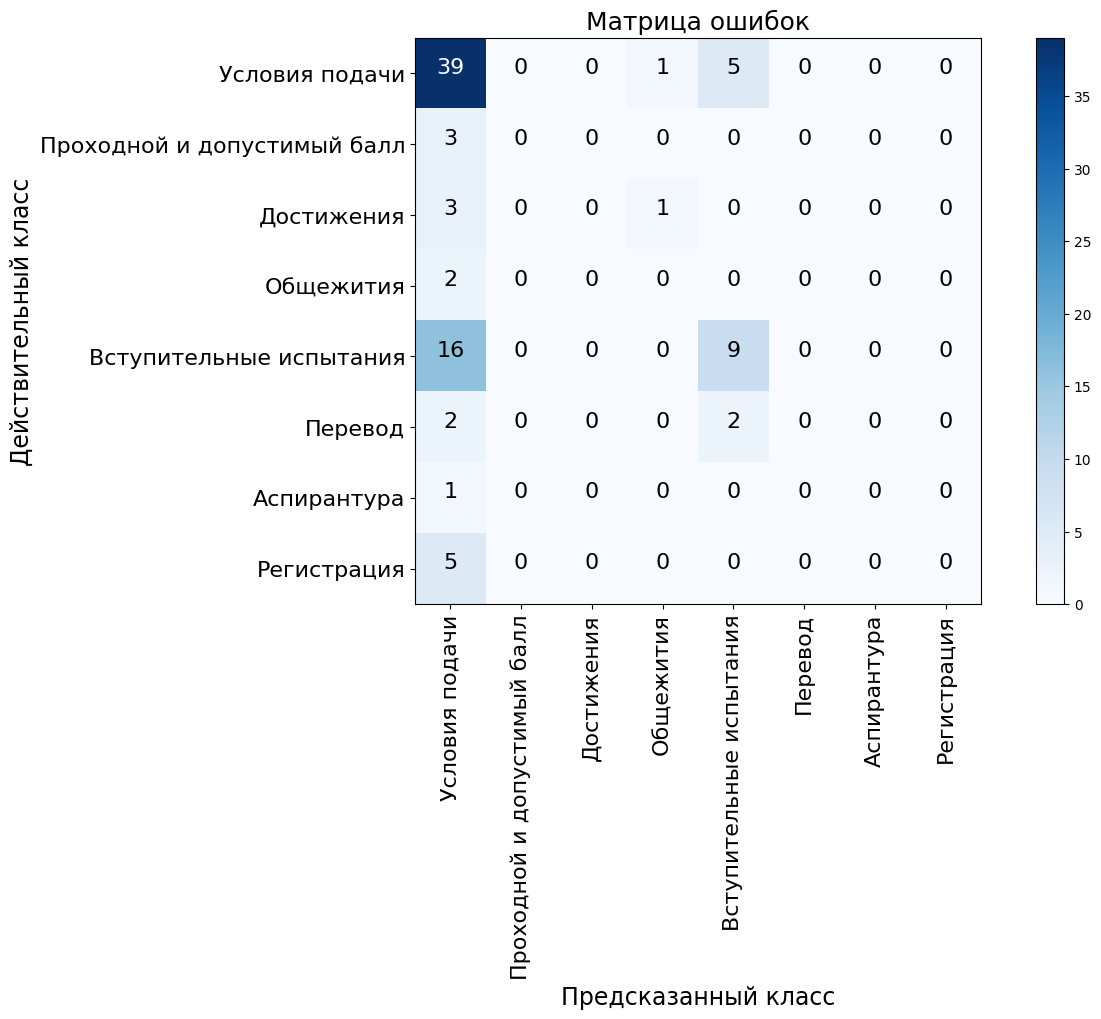

In [45]:
%pip install xgboost
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost # подключим библиотеку XGboost

Y_train = np.argmax(y_train, axis=1)-1
Y_test = np.argmax(y_test, axis=1)-1

estimators = [('RandomForestClassifier', RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             max_features=2)),
              ('XGBClassifier', xgboost.XGBClassifier()),
              ('Tree', DecisionTreeClassifier(max_depth=5))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, Y_train)  # Обучение
y_pred = clf.predict(X_test)+1 # Предсказание классов тестовых данных
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)